In [115]:
import scipy.io as sio
from scipy.io import readsav

import numpy as np
import math as m

import matplotlib.pyplot as plt
import matplotlib as mpl

from astropy.io import fits
import pandas as pd
from scipy.optimize import curve_fit
from scipy import interpolate
from scipy.interpolate import interp1d
import mpyfit

In [116]:
s = readsav('hd212657/hd212657ccfs.idl')
txt_file = pd.read_csv("hd212657/HD212657.RV.txt",delimiter="\t")

s_pd = pd.DataFrame(list(zip(s["jdb"], s["ccfs"],s["wls"], s["vrad"]*1000, 
                             txt_file["svrad"], txt_file["fwhm"], txt_file["contrast"],
                             txt_file["bis_span"], txt_file["noise"], txt_file["s_mw"])), 
               columns =['bjd', 'ccf', 'wls', 'vrad', 
                         'svrad', 'fwhm', 'contrast', 
                         'bis_span','noise', 's_mw']) 
s_pd_clean = s_pd.drop([16,21,41])
s_pd_clean = s_pd_clean.reset_index(drop=True)


Text(0.5, 0, 'km/s')

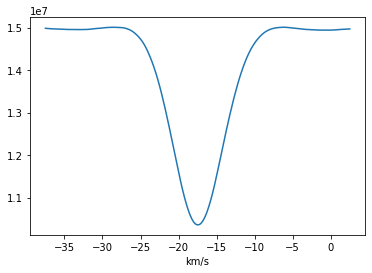

In [119]:
plt.plot(s_pd["wls"][0], s_pd["ccf"][0])
plt.xlabel("km/s")

Text(0, 0.5, 'RV (m/s)')

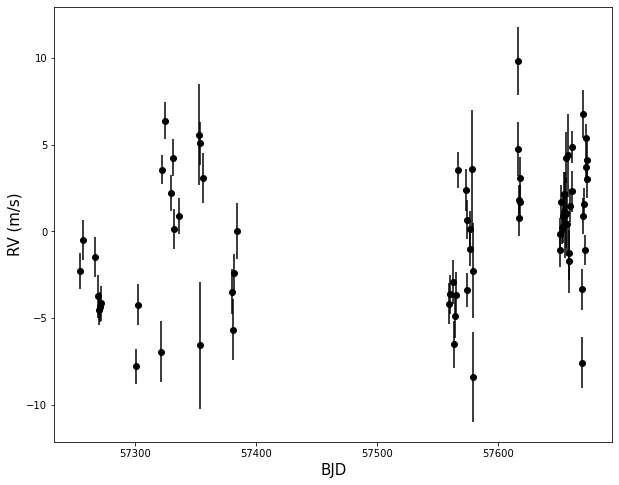

In [113]:
fig, ax = plt.subplots(1,1, figsize=(10, 8))

x = s_pd_clean["bjd"]
y = s_pd_clean["vrad"]-np.mean(s_pd_clean["vrad"])
yerr = s_pd_clean["svrad"]

#ax[0].scatter(txt_file["BJD_UTC"]-2400000, txt_file["vrad"]-np.mean(txt_file["vrad"]))
ax.errorbar(x, y, yerr = yerr, fmt = 'o', color='k')
ax.set_xlabel("BJD", size=15)
ax.set_ylabel("RV (m/s)",size=15)

max: 4156622.0 at index: 80
half-max1: 81464.0 at index: (array([65]),)
7.5
[30]
[65]
(array([15]),)


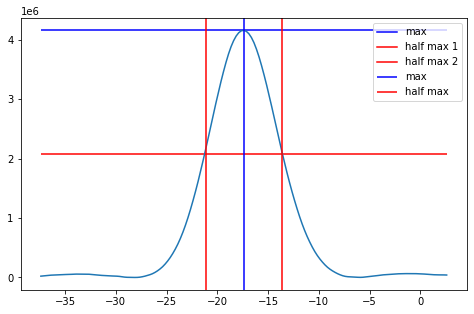

In [11]:
x = -ccf_data - np.min(-ccf_data)
maxval = np.max(x)
ind = np.argmax(x)
print("max: "+str(maxval)+" at index: "+str(ind))

half1 = x[0:ind]
half2 = x[ind:]

h1 = np.abs(half1-(maxval/2.))
h2 = np.abs(half2-(maxval/2.))

min1 = np.min(h1)
ind1 = np.where(h1 == min1)
print("half-max1: "+str(min1)+" at index: "+str(ind1))

min2 = np.min(h2)
ind2 = np.where(h2==min2)

fwhm = ind2[0] +ind - ind1[0]
print(x_axis[fwhm[0]]-x_axis[0])

fig, ax = plt.subplots(1,1, figsize=(8, 5))
plt.plot(x_axis, x)
plt.axvline(x=x_axis[ind], label="max", color="b")
plt.hlines(y=maxval, xmin= np.min(x_axis), xmax=np.max(x_axis), label="max", color="b")
plt.axvline(x_axis[ind1], label="half max 1", color="r")
plt.axvline(x_axis[ind2+ind], label="half max 2", color="r")
plt.hlines(y=maxval/2, xmin= np.min(x_axis), xmax=np.max(x_axis), label="half max", color="r")
#plt.plot([np.min(x_axis), np.max(x_axis)], [maxval, maxval])
plt.legend()
#plt.plot([np.min(x_axis), np.max(x_axis)], [maxval/2., maxval/2.])
#plt.plot(h1)
print(fwhm)
print(ind1[0])
print(ind2)


In [6]:
# A simple fwhm finder 
# flip over ccf, find max, find half max locations, distance between those two locations, divide
def fwhm_sigma(ccf, axis):
    x = -ccf - np.min(-ccf)
    maxval = np.max(x)
    ind = np.argmax(x)
    #print("max: "+str(maxval)+" at index: "+str(ind))

    half1 = x[0:ind]
    half2 = x[ind:]

    h1 = np.abs(half1-(maxval/2.))
    h2 = np.abs(half2-(maxval/2.))

    min1 = np.min(h1)
    ind1 = np.where(h1 == min1)
    #print("half-max1: "+str(min1)+" at index: "+str(ind1))

    min2 = np.min(h2)
    ind2 = np.where(h2==min2)

    fwhm = ind2[0] +ind - ind1[0]
    
    #return fwhm, sigma
    return axis[fwhm[0]]-axis[0], (axis[fwhm[0]]-axis[0])/2.335

In [10]:
fwhm_sigma(ccf_data, x_axis)[1]

3.2119914346895078

In [114]:
# define empty lists

num_ccfs = len(s_pd_clean['wls'])
mpy_coeff_list = []
bjd_list = []
x_diff_list = []
x_axis_ref_shift_list = []
x_axis_zero_shift_list = []
x_axis_mean_shift_list = []
og_ccf_list = []
ref_shifted_CCF_data_list = []
mean_shifted_CCF_data_list = []
mu_og_list = []
mu_ref_list = []
mu_zero_list = []
sigma_og_list = []
CCF_normalized_list = []

# Finds the local minima using a Gaussian fit
# Define the actual function where     A = p[0], mu = p[1], sigma = p[2], c = p[3]
def gauss(x, p):
    return -p[0] * np.exp(-(x - p[1]) ** 2 / (2. * p[2] ** 2)) + p[3]

# A simple minimization function:
def least(p, args):
    x, y = args
    return gauss(x, p) - y

for i in range(0, num_ccfs):#(0, num_ccfs):
    bjd = s_pd_clean["bjd"][i]
    bjd_list.append(bjd)
    
    # extracts the ccf data and rv
    ccf_data = s_pd_clean["ccf"][i]
    og_ccf_list.append(ccf_data)
    rv = s_pd_clean["vrad"][i]
    fwhm = s_pd_clean["fwhm"][i]
    contrast = s_pd_clean["contrast"][i]
    bis_span = s_pd_clean["bis_span"][i]
    noise = s_pd_clean["noise"][i]
    s_mw = s_pd_clean["s_mw"][i]
    
    parinfo = [{'fixed': False, 'step': 1e-4*np.max(ccf_data)},
                           {'fixed': False, 'step': 1e-6},
                           {'fixed': False, 'step': 1e-4},
                           {'fixed': False, 'step': 1e-4*np.max(ccf_data)}]
    
    # original (og) fit before any shifting
    x_axis = s_pd_clean["wls"][i]
    amp_og_guess = np.max(ccf_data)-np.min(ccf_data)
    offset_og_guess = np.max(ccf_data)
    index_og = np.argmin(ccf_data)
    sigma_og = fwhm_sigma(ccf_data, x_axis)[1]
    sigma_og_list.append(sigma_og)
    
    # flip over ccf, find max, find half max locations, distance between those two locations, divide
    p_og_guess = [amp_og_guess, x_axis[index_og], sigma_og, offset_og_guess]
    pfit_og, p_results_og = mpyfit.fit(least, p_og_guess, (x_axis, ccf_data), parinfo)
    mu_og = pfit_og[1]
    mu_og_list.append(mu_og)
    
    # shift to the same reference frame
    x_diff =s_pd_clean["wls"][0][0]-s_pd_clean["wls"][i][0]
    x_diff_list.append(x_diff)
    x_axis_ref_shift = x_axis + x_diff
    x_axis_ref_shift_list.append(x_axis_ref_shift)
    f_ref = interp1d(x_axis, ccf_data, kind='cubic', fill_value='extrapolate')
    ref_shifted_CCF_data = f_ref(x_axis_ref_shift)
    ref_shifted_CCF_data_list.append(ref_shifted_CCF_data)
    
    # calculate index of max for initial guess for mu 
    index_ref = np.argmin(ref_shifted_CCF_data)
    sigma_ref = fwhm_sigma(ref_shifted_CCF_data, s_pd_clean["wls"][0])[1]
    
    # fit the reference frame shifted rvs
    p_ref_guess = [amp_og_guess, x_axis_ref_shift[index_ref], sigma_ref, offset_og_guess]
    pfit_ref, p_results_ref = mpyfit.fit(least, p_ref_guess, (x_axis_ref_shift, ref_shifted_CCF_data), parinfo)
    mu_ref = pfit_ref[1]
    mu_ref_list.append(mu_ref)
    
    # shift to mean
    shift_to_mean = (np.mean(s_pd_clean["vrad"]) - rv )*0.001
    #print("shift to mean: " +str(shift_to_mean))
    x_axis_mean_shift = x_axis_ref_shift + shift_to_mean
    x_axis_mean_shift_list.append(x_axis_mean_shift)
    f_mean = interp1d(x_axis_mean_shift, ref_shifted_CCF_data, kind='cubic', fill_value='extrapolate')
    mean_shifted_CCF_data = f_mean(x_axis_ref_shift)
    mean_shifted_CCF_data_list.append(mean_shifted_CCF_data)
    
    # calculate index of max for initial guess for mu 
    index_mean = np.argmin(mean_shifted_CCF_data)
    
    # fit the zero shifted rvs
    p_zero_guess = [amp_og_guess, x_axis_ref_shift[index_mean], sigma_ref, offset_og_guess]
    pfit_zero, p_results_zero = mpyfit.fit(least, p_zero_guess, (x_axis_ref_shift, mean_shifted_CCF_data), parinfo)
    mu_zero = pfit_zero[1]
    #print("zero mu: "+str(mu_zero))
    mu_zero_list.append(mu_zero)
    
    # Normalizes the CCFs
    x_left = mean_shifted_CCF_data[0:40]
    x_right = mean_shifted_CCF_data[121:161]
    x_norm_range = list(x_left) + list(x_right)
    CCF_normalized = mean_shifted_CCF_data*(1/np.mean(x_norm_range))
    CCF_normalized_list.append(CCF_normalized)

    # finds center of mass
    #center_of_mass = np.sum((1-CCF_data)*rv_data)/(np.sum(1-CCF_data))
    #print(center_of_mass)

    #creates columns in CCF.fits files
    #col1 = fits.Column(name='RV data', format='E', array=x_axis_ref_shift)
    #col2 = fits.Column(name='CCF data', format='E', array=CCF_normalized)
    ##col3 = fits.Column(name='CCF data rescaled', format='E', array=CCF_rescaled)
    #cols = fits.ColDefs([col1, col2]) #, col3])

    #tbhdu = fits.BinTableHDU.from_columns(cols)

    #hdu = fits.PrimaryHDU()
    #hdu = fits.PrimaryHDU()
    #hdulist = fits.HDUList([hdu])

    #tbhdu = fits.BinTableHDU.from_columns(cols)
    #hdu_new = fits.ImageHDU()
    #hdr = fits.Header()
    #primary_hdu = fits.PrimaryHDU(header=hdr)
    #hdul = fits.HDUList([primary_hdu, hdu_new])

    #hdul[0].header.set('label', s_pd_clean['vrad'][i], 'RV [km/s]')
    #hdul[0].header.set('s_label', s_pd_clean['svrad'][i], 'RV [km/s]')
    #hdul[0].header.set("BJD", bjd, 'Barycentric JD (from DRS)')
    #hdul[0].header.set('MU_og', mu_og, 'km/s')
    #hdul[0].header.set('mu_ref', mu_ref, 'km/s')
    #hdul[0].header.set('MU_zero', mu_zero, 'km/s')

    #hdul[0].header.set('fwhm', fwhm, 'CCF FWHM from DRS')
    #hdul[0].header.set('contrast', contrast, 'CCF contrast from DRS')
    #hdul[0].header.set('bis', bis_span, 'CCF BIS Span from DRS')
    #hdul[0].header.set('noise', noise, 'noise from DRS')
    #hdul[0].header.set('s_mw', s_mw, 's_mw from DRS')


    #hdul.append(tbhdu)

    #uncomment below if you want to write files
    #hdul.writeto('hd212657/shifted_fits_clean73_Jan4/ccf' + str(i)+'.fits')
    #hdul.close()

# write it all to one file
#creates columns in CCF.fits files
col1 = fits.Column(name='bjd', format='E', array=bjd_list)

# ccf params
col2 = fits.Column(name='og_ccf_list', format='161E', dim='(73)', array=og_ccf_list)
col3 = fits.Column(name='ref_shifted_CCF_data_list',format='161E', dim='(73)', array=ref_shifted_CCF_data_list)
col4 = fits.Column(name='mean_shifted_CCF_data_list', format='161E',  dim='(73)', array=mean_shifted_CCF_data_list)
col5 = fits.Column(name='CCF_normalized_list', format='161E', dim='(73)', array=CCF_normalized_list)
col6 = fits.Column(name='mu_og_list', format='E', array=mu_og_list)
col7 = fits.Column(name='mu_ref_list', format='E', array=mu_ref_list)
col8 = fits.Column(name='mu_zero_list', format='E', array=mu_zero_list)

# rv and textfile params
col9 = fits.Column(name='vrad', format='E', array=s_pd_clean["vrad"])
col10 = fits.Column(name='svrad', format='E', array=s_pd_clean["svrad"])
col11 = fits.Column(name='fwhm', format='E', array=s_pd_clean["fwhm"])
col12 = fits.Column(name='contrast', format='E', array=s_pd_clean["contrast"])
col13 = fits.Column(name='bis_span', format='E', array=s_pd_clean["bis_span"])
col14 = fits.Column(name='noise', format='E', array=s_pd_clean["noise"])
col15 = fits.Column(name='s_mw', format='E', array=s_pd_clean["s_mw"])

cols1 = fits.ColDefs([col2, col3, col4, col5])

cols2 = fits.ColDefs([col1, col6, col7, col8,
                    col9, col10, col11, col12, col13, col14, col15])

#hdu = fits.PrimaryHDU()
primary_hdu = fits.PrimaryHDU()
t = fits.BinTableHDU.from_columns([col2, col3, col4, col5])
table_hdu2 = fits.BinTableHDU.from_columns([col1, col6, col7, col8,
                    col9, col10, col11, col12, col13, col14, col15])

hdul = fits.HDUList([primary_hdu, t, table_hdu2])
hdul.writeto('hd212657/shifted_fits_clean73_Jan14_one_file/shifted_ccfs_combined.fits')
hdul.close()

#tbhdu = fits.BinTableHDU.from_columns(cols1)
#hdu_new = fits.ImageHDU()
#hdr = fits.Header()
#primary_hdu = fits.PrimaryHDU(header=hdr)
#hdul = fits.HDUList([primary_hdu, hdu_new])
#hdul.writeto('hd212657/shifted_fits_clean73_Jan14_one_file/shifted_ccfs.fits')
#hdul.close()
    

In [111]:
len(s["vrad"])

76

In [124]:
# open fits file to check contents
hdul_open = fits.open('hd212657/shifted_fits_clean73_Jan14_one_file/shifted_ccfs_combined.fits', memmap=False)
open_vrad_list = hdul_open[2].data['vrad']
open_ccf_norm_list = hdul_open[1].data["CCF_normalized_list"]

0.0 1.0


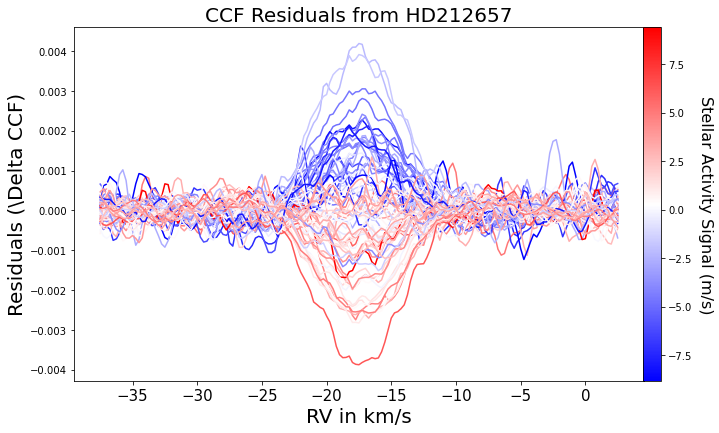

In [171]:
# plot ccfs
min_rv = np.min(open_vrad_list)
max_rv = np.max(open_vrad_list)
cscale_residuals = (np.array(open_vrad_list -min_rv)/ (max_rv-min_rv))
print(np.min(cscale_residuals), np.max(cscale_residuals))

#plt.hist(cscale_residuals)

fig, ax = plt.subplots(1,1, figsize=(12, 6.5))

col = plt.cm.jet([0.25,0.75])
n = len(open_ccf_norm_list)
colors = plt.cm.bwr(cscale_residuals)

median_ccf = np.median(open_ccf_norm_list, axis=0)
num = 0
for i in open_ccf_norm_list:
    plt.plot(s_pd_clean["wls"][0], i-median_ccf, color = colors[num])
    num += 1

ax.tick_params(axis='x', labelsize= 15)
#ax.set_xticks([-40, -30, -20, -10, 0])
ax.set_xlabel("RV in km/s", size=20)
ax.set_ylabel("Residuals (\Delta CCF)", size=20)
ax.set_title("CCF Residuals from HD212657", size=20)
#ax.get_yaxis().set_visible(False)

cmap = mpl.cm.bwr
norm = mpl.colors.Normalize(vmin=(min_rv-np.median(open_vrad_list)), vmax=(max_rv-np.median(open_vrad_list)))

#cb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
#             , orientation='vertical', label='Radial Velocities (m/s)')

cb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), orientation="vertical", pad=-0.0001)
cb.set_label(label='Stellar Activity Signal (m/s)', size=16, rotation=270, labelpad=20)

0.0 1.0


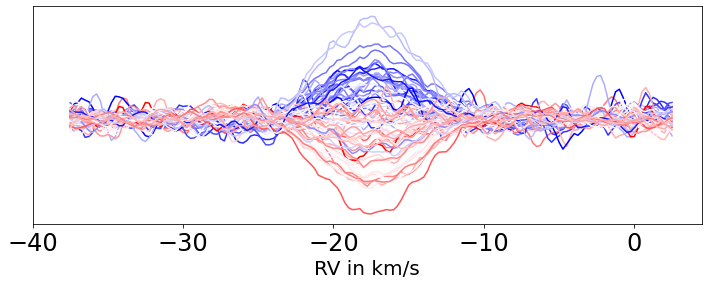

In [155]:
# plot ccfs
min_rv = np.min(open_vrad_list)
max_rv = np.max(open_vrad_list)
cscale_residuals = (np.array(open_vrad_list -min_rv)/ (max_rv-min_rv))
print(np.min(cscale_residuals), np.max(cscale_residuals))

#plt.hist(cscale_residuals)

fig, ax = plt.subplots(1,1, figsize=(12, 4))

col = plt.cm.jet([0.25,0.75])
n = len(open_ccf_norm_list)
colors = plt.cm.bwr(cscale_residuals)

median_ccf = np.median(open_ccf_norm_list, axis=0)
num = 0
for i in open_ccf_norm_list:
    plt.plot(s_pd_clean["wls"][0], i-median_ccf, color = colors[num])
    num += 1

ax.tick_params(axis='x', labelsize= 24)
ax.set_xticks([-40, -30, -20, -10, 0])
ax.set_xlabel("RV in km/s", size=20)
ax.get_yaxis().set_visible(False)

In [73]:
len(CCF_normalized_list[0])*len(CCF_normalized_list)

11753

In [12]:
# write to one text file


shifted_pd = pd.DataFrame(list(zip(bjd_list, 
                                   og_ccf_list, ref_shifted_CCF_data_list, mean_shifted_CCF_data_list,CCF_normalized_list,
                                   mu_og_list, mu_ref_list, mu_zero_list,
                                   s["vrad"]*1000, txt_file["svrad"], txt_file["fwhm"], txt_file["contrast"],
                                   txt_file["bis_span"], txt_file["noise"], txt_file["s_mw"])), 
               columns =['bjd', 
                         'og_ccf', 'ref_ccf', 'mean_ccf', 'norm_shifted_ccf',
                         'mu_og', 'mu_ref', 'mu_zero',
                         'vrad','svrad', 'fwhm', 'contrast', 
                         'bis_span','noise', 's_mw']) 

shifted_pd.to_csv('hd212657/shifted_fits_clean73_Jan7_one_file/shifted_ccfs.txt', index=False)

In [67]:
from astropy.table import Table
t = Table.from_pandas(shifted_pd)
t

#t.write('hd212657/test_table.fits', overwrite=True)
#new_table = Table.read('test_table.fits')

bjd,og_ccf,ref_ccf,mean_ccf,norm_shifted_ccf,mu_og,mu_ref,mu_zero,vrad,svrad,fwhm,contrast,bis_span,noise,s_mw
float64,object,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
57254.593124,[14983578. 14979255. 14975776. 14972936. 14970866. 14968651. 14966722. 14964372. 14962301. 14960665. 14959289. 14957439. 14955879. 14955232. 14954585. 14954306. 14954380. 14954418. 14953761. 14953958. 14954433. 14955458. 14956713. 14959663. 14964440. 14970297. 14975982. 14980066. 14982659. 14986169. 14991346. 14996545. 15001145. 15003810. 15005638. 15007144. 15007294. 15006355. 15004597. 15002871. 15000148. 14995359. 14985928. 14971488. 14954436. 14931991. 14903765. 14868740. 14828163. 14781726. 14729579. 14668122. 14596506. 14513723. 14417982. 14313220. 14200319. 14075137. 13938080. 13791040. 13629458. 13457857. 13275157. 13082188. 12881800. 12675411. 12462510. 12247156. 12030884. 11814134. 11602350. 11397908. 11204083. 11025233. 10862911. 10718511. 10595358. 10495550. 10421228. 10376074. 10358545. 10367765. 10404910. 10469754. 10558308. 10670918. 10805492. 10957959. 11129087. 11315431. 11514853. 11722044. 11933460. 12145508. 12355632. 12562028. 12763057. 12959317. 13147932. 13327821. 13499080. 13660063. 13810468. 13948996. 14078610. 14197331. 14305432. 14403155. 14490549. 14567848. 14636664. 14699000. 14753050. 14801498. 14844058. 14881071. 14911174. 14935676. 14955630. 14971313. 14983865. 14992963. 14999299. 15003436. 15006507. 15008522. 15007634. 15004990. 15000110. 14995549. 14990233. 14986369. 14982407. 14977123. 14970790. 14965167. 14961170. 14957214. 14954602. 14952215. 14949554. 14945663. 14942639. 14940655. 14941143. 14941002. 14940616. 14939672. 14938992. 14939816. 14940989. 14943157. 14945263. 14948315. 14952827. 14956258. 14959177. 14960778. 14962299. 14965659. 14968742.],[14983578. 14979255. 14975776. 14972936. 14970866. 14968651. 14966722. 14964372. 14962301. 14960665. 14959289. 14957439. 14955879. 14955232. 14954585. 14954306. 14954380. 14954418. 14953761. 14953958. 14954433. 14955458. 14956713. 14959663. 14964440. 14970297. 14975982. 14980066. 14982659. 14986169. 14991346. 14996545. 15001145. 15003810. 15005638. 15007144. 15007294. 15006355. 15004597. 15002871. 15000148. 14995359. 14985928. 14971488. 14954436. 14931991. 14903765. 14868740. 14828163. 14781726. 14729579. 14668122. 14596506. 14513723. 14417982. 14313220. 14200319. 14075137. 13938080. 13791040. 13629458. 13457857. 13275157. 13082188. 12881800. 12675411. 12462510. 12247156. 12030884. 11814134. 11602350. 11397908. 11204083. 11025233. 10862911. 10718511. 10595358. 10495550. 10421228. 10376074. 10358545. 10367765. 10404910. 10469754. 10558308. 10670918. 10805492. 10957959. 11129087. 11315431. 11514853. 11722044. 11933460. 12145508. 12355632. 12562028. 12763057. 12959317. 13147932. 13327821. 13499080. 13660063. 13810468. 13948996. 14078610. 14197331. 14305432. 14403155. 14490549. 14567848. 14636664. 14699000. 14753050. 14801498. 14844058. 14881071. 14911174. 14935676. 14955630. 14971313. 14983865. 14992963. 14999299. 15003436. 15006507. 15008522. 15007634. 15004990. 15000110. 14995549. 14990233. 14986369. 14982407. 14977123. 14970790. 14965167. 14961170. 14957214. 14954602. 14952215. 14949554. 14945663. 14942639. 14940655. 14941143. 14941002. 14940616. 14939672. 14938992. 14939816. 14940989. 14943157. 14945263. 14948315. 14952827. 14956258. 14959177. 14960778. 14962299. 14965659. 14968742.],[14983622.24371406 14979289.75398659 14975804.92330816 14972957.39306554 14970885.09513343 14968669.61191717 14966741.11689174 14964393.07495011 14962317.76697974 14960677.68070092 14959303.40829845 14957456.21822981 14955888.43693581 14955237.22089281 14954589.83726485 14954306.67910929 14954378.10287695 14954421.85785051 14953764.11300675 14953954.39698966 14954426.11008662 14955448.54382066 14956695.82542322 14959627.32349539 14964390.39274618 14970242.45332012 14975936.16434696 14980038.07937698 14982634.74167537 14986128.3634

In [62]:
shifted_pd['og_ccf']

0     [14983578.0, 14979255.0, 14975776.0, 14972936....
1     [11745628.0, 11744986.0, 11743543.0, 11741887....
2     [11370518.0, 11370015.0, 11368927.0, 11367284....
3     [9944056.0, 9940992.0, 9939069.0, 9937724.0, 9...
4     [21964384.0, 21957742.0, 21952028.0, 21947840....
                            ...                        
68    [21062130.0, 21056196.0, 21053632.0, 21052610....
69    [19997164.0, 19992346.0, 19987076.0, 19981274....
70    [27738070.0, 27732616.0, 27726738.0, 27719684....
71    [13362156.0, 13361725.0, 13360224.0, 13358341....
72    [13427893.0, 13423525.0, 13418655.0, 13413681....
Name: og_ccf, Length: 73, dtype: object

In [58]:
from tempfile import TemporaryFile
outfile = TemporaryFile()
np.savez_compressed('hd212657/shifted_fits_clean73_Jan7_one_file/shifted_ccfs_np', bjd =shifted_pd['bjd'], 
         og_ccf = shifted_pd['og_ccf'], ref_ccf = shifted_pd['ref_ccf'], mean_ccf= shifted_pd['mean_ccf'],
         norm_shifted_ccf = shifted_pd['norm_shifted_ccf'], 
         mu_og = shifted_pd['mu_og'], mu_ref = shifted_pd['mu_ref'], mu_zero = shifted_pd['mu_zero'],
         vrad = shifted_pd['vrad'],svrad = shifted_pd['svrad'], fwhm = shifted_pd['fwhm'], 
         contrast = shifted_pd['contrast'],bis_span = shifted_pd['bis_span'],
         noise = shifted_pd['noise'], s_mw = shifted_pd['s_mw'])
testing123 = outfile.seek(0)
npzfile = np.load('hd212657/shifted_fits_clean73_Jan7_one_file/shifted_ccfs_np.npz')
npzfile.files

['bjd',
 'og_ccf',
 'ref_ccf',
 'mean_ccf',
 'norm_shifted_ccf',
 'mu_og',
 'mu_ref',
 'mu_zero',
 'vrad',
 'svrad',
 'fwhm',
 'contrast',
 'bis_span',
 'noise',
 's_mw']

In [61]:
npzfile['og_ccf']

ValueError: Object arrays cannot be loaded when allow_pickle=False

In [694]:
pd_written_file = pd.read_csv("hd212657/shifted_fits_clean73_Jan7_one_file/shifted_ccfs.txt")
pd_written_file

,bjd,og_ccf,ref_ccf,mean_ccf,norm_shifted_ccf,mu_og,mu_ref,mu_zero,vrad,svrad,fwhm,contrast,bis_span,noise,s_mw
0,57254.593124,[14983578. 14979255. 14975776. 14972936. 14970...,[14983578. 14979255. 14975776. 14972936. 14970...,[14983622.24371406 14979289.75398659 14975804....,[1.00090116 1.00061175 1.00037896 1.00018875 1...,-17.424084,-17.424084,-17.421820,-17424.22,1.03,7615.54,30.860,59.04,0.96,0.00
1,57257.578995,[11745628. 11744986. 11743543. 11741887. 1...,[11745628. 11744986. 11743543. 11741887. 1...,[11745627.85974124 11744988.36596237 11743546....,[1.00053891 1.00048444 1.00036158 1.00022058 1...,-17.421527,-17.421527,-17.421033,-17422.45,1.15,7613.57,30.786,62.07,1.09,0.00
2,57267.619795,[11370518. 11370015. 11368927. 11367284. 1...,[11370518. 11370015. 11368927. 11367284. 1...,[11370518.11327485 11370020.23439642 11368934....,[1.00086839 1.00082457 1.00072896 1.00058503 1...,-17.423703,-17.423703,-17.422229,-17423.43,1.17,7621.53,30.692,60.57,1.12,0.00
3,57269.560355,[9944056. 9940992. 9939069. 9937724. 99383...,[9944056. 9940992. 9939069. 9937724. 99383...,[9944118.22875929 9941025.7227411 9939096.715...,[1.0007673 1.00045607 1.00026193 1.00012405 1...,-17.426463,-17.426463,-17.422719,-17425.70,1.25,7619.69,30.672,58.82,1.20,0.00
4,57270.543983,[21964384. 21957742. 21952028. 21947840. 21941...,[21964384. 21957742. 21952028. 21947840. 21941...,[21964500.84642557 21957860.12716667 21952111....,[1.00107874 1.00077608 1.00051408 1.00032334 1...,-17.425920,-17.425920,-17.421386,-17426.49,0.87,7618.71,30.670,63.70,0.80,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,57671.506236,[21062130. 21056196. 21053632. 21052610. 21048...,[21065595.55116675 21058128.06389268 21054295....,[21065634.8492498 21058152.2727259 21054303....,[1.00088518 1.00052966 1.00034682 1.00029386 1...,-17.423547,-17.423547,-17.422482,-17415.20,1.39,7608.98,31.240,59.02,1.34,0.15
69,57672.422952,[19997164. 19992346. 19987076. 19981274. 19976...,[19999139.54499069 19994283.67678265 19989288....,[19999061.91459572 19994213.75953605 19989206....,[1.00108505 1.00084237 1.00059171 1.00030315 1...,-17.417474,-17.417472,-17.421188,-17421.06,1.05,7606.50,31.105,58.11,0.99,0.15
70,57672.508652,[27738070. 27732616. 27726738. 27719684. 27713...,[27740457.7395851 27734767.22278368 27729232....,[27740321.01402296 27734652.10782212 27729102....,[1.00092739 1.00072284 1.00052259 1.00028074 1...,-17.416156,-17.416156,-17.421561,-17420.37,0.92,7602.12,31.088,57.96,0.86,0.15
71,57673.416804,[13362156. 13361725. 13360224. 13358341. 13355...,[13361788.41986177 13362085.89332677 13360884....,[13361806.20136549 13362077.65036357 13360866....,[1.00052056 1.00054089 1.00045016 1.00032154 1...,-17.418481,-17.418481,-17.421487,-17423.02,0.88,7610.45,30.985,57.82,0.81,0.15


In [632]:
np.mean(s_pd_clean["vrad"])*0.001

-17.42195589041096

In [634]:
rv*0.001

-17.41786

In [629]:
shift_to_mean

-0.004095890410957509

In [588]:
s_pd_clean["wls"][0][0] - s_pd_clean["wls"][i][0]

-0.09999847412109375

og mu: -17.417648799808433
ref mu: -17.417647664532964
shift to mean: -0.004095890410957509
zero mu: -17.42174358613404


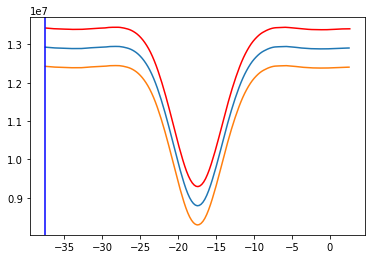

In [645]:
    parinfo = [{'fixed': False, 'step': 1e-4*np.max(ccf_data)},
                           {'fixed': False, 'step': 1e-6},
                           {'fixed': False, 'step': 1e-4},
                           {'fixed': False, 'step': 1e-4*np.max(ccf_data)}]
    
    # original (og) fit before any shifting
    x_axis = s_pd_clean["wls"][i]
    amp_og_guess = np.max(ccf_data)-np.min(ccf_data)
    offset_og_guess = np.max(ccf_data)
    index_og = np.argmin(ccf_data)
    sigma_og = fwhm_sigma(ccf_data, x_axis)[1]
    sigma_og_list.append(sigma_og)
    
    # flip over ccf, find max, find half max locations, distance between those two locations, divide
    p_og_guess = [amp_og_guess, x_axis[index_og], sigma_og, offset_og_guess]
    pfit_og, p_results_og = mpyfit.fit(least, p_og_guess, (x_axis, ccf_data), parinfo)
    mu_og = pfit_og[1]
    print("og mu: "+str(mu_og))
    mu_og_list.append(mu_og)
    
    # shift to the same reference frame
    x_diff =s_pd_clean["wls"][0][0]-s_pd_clean["wls"][i][0]
    x_diff_list.append(x_diff)
    x_axis_ref_shift = x_axis + x_diff
    x_axis_ref_shift_list.append(x_axis_ref_shift)
    f_ref = interp1d(x_axis, ccf_data, kind='cubic', fill_value='extrapolate') 
    ref_shifted_CCF_data = f_ref(x_axis_ref_shift)
    ref_shifted_CCF_data_list.append(ref_shifted_CCF_data)
    
    # calculate index of max for initial guess for mu 
    index_ref = np.argmin(ref_shifted_CCF_data)
    sigma_ref = fwhm_sigma(ccf_data, s_pd_clean["wls"][0])[1]
    
    # fit the reference frame shifted rvs
    p_ref_guess = [amp_og_guess, x_axis_ref_shift[index_ref], sigma_ref, offset_og_guess]
    pfit_ref, p_results_ref = mpyfit.fit(least, p_ref_guess, (x_axis_ref_shift, ref_shifted_CCF_data), parinfo)
    mu_ref = pfit_ref[1]
    print("ref mu: "+str(mu_ref))
    mu_ref_list.append(mu_ref)
    
    # shift to mean
    shift_to_mean = (np.mean(s_pd_clean["vrad"]) - rv )*0.001
    print("shift to mean: " +str(shift_to_mean))
    x_axis_mean_shift = x_axis_ref_shift + shift_to_mean
    x_axis_mean_shift_list.append(x_axis_mean_shift)
    f_mean = interp1d(x_axis_mean_shift, ref_shifted_CCF_data, kind='cubic', fill_value='extrapolate')
    mean_shifted_CCF_data = f_mean(x_axis_ref_shift)
    mean_shifted_CCF_data_list.append(mean_shifted_CCF_data)
    
    # calculate index of max for initial guess for mu 
    index_mean = np.argmin(mean_shifted_CCF_data)
    
    # fit the zero shifted rvs
    p_zero_guess = [amp_og_guess, x_axis_ref_shift[index_mean], sigma_ref, offset_og_guess]
    pfit_zero, p_results_zero = mpyfit.fit(least, p_zero_guess, (x_axis_ref_shift, mean_shifted_CCF_data), parinfo)
    mu_zero = pfit_zero[1]
    print("zero mu: "+str(mu_zero))
    mu_zero_list.append(mu_zero)
    
    
    plt.plot(x_axis, ccf_data, label="og", color="r")
    plt.plot(x_axis_ref_shift, ref_shifted_CCF_data-0.5e6, label="ref")
    plt.plot(x_axis_ref_shift, mean_shifted_CCF_data-1e6, label="ref")
    #plt.xlim(np.min(x_axis)-0.3, -37.1)
    plt.axvline(-37.5, label="half max 1", color="b")
    #plt.ylim(np.min(x_axis), -35)

Text(0.5, 0, 'BJD')

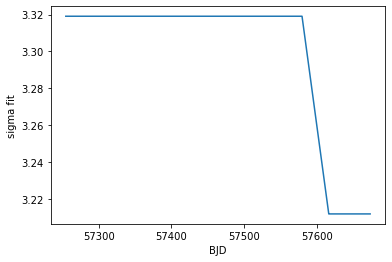

In [508]:
plt.plot(s_pd_clean["bjd"], sigma_og_list)
plt.ylabel("sigma fit")
plt.xlabel("BJD")

og mu: -17.4220386743236
ref mu: -16.922037371779613
median mu: -16.42204522668653


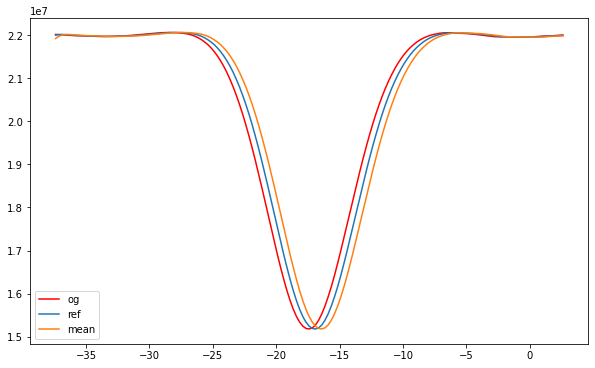

In [579]:
    parinfo = [{'fixed': False, 'step': 1e-4*np.max(ccf_data)},
                           {'fixed': False, 'step': 1e-6},
                           {'fixed': False, 'step': 1e-4},
                           {'fixed': False, 'step': 1e-4*np.max(ccf_data)}]
    
    # original (og) fit before any shifting
    x_axis = s_pd_clean["wls"][i]
    amp_og_guess = np.max(ccf_data)-np.min(ccf_data)
    offset_og_guess = np.max(ccf_data)
    index_og = np.argmin(ccf_data)
    sigma_og = fwhm_sigma(ccf_data, x_axis)[1]
    sigma_og_list.append(sigma_og)
    
    # flip over ccf, find max, find half max locations, distance between those two locations, divide
    p_og_guess = [amp_og_guess, x_axis[index_og], sigma_og, offset_og_guess]
    pfit_og, p_results_og = mpyfit.fit(least, p_og_guess, (x_axis, ccf_data), parinfo)
    mu_og = pfit_og[1]
    print("og mu: "+str(mu_og))
    mu_og_list.append(mu_og)
    
    # shift to the same reference frame
    x_diff =0.5
    x_axis_ref_shift = x_axis + x_diff
    x_axis_ref_shift_list.append(x_axis_ref_shift)
    f_ref = interp1d(x_axis_ref_shift, ccf_data, kind='cubic', fill_value='extrapolate')
    ref_shifted_CCF_data = f_ref(x_axis)
    ref_shifted_CCF_data_list.append(ref_shifted_CCF_data)
    
    # calculate index of max for initial guess for mu 
    index_ref = np.argmin(ref_shifted_CCF_data)
    sigma_ref = fwhm_sigma(ccf_data, s_pd_clean["wls"][0])[1]
    
    # fit the reference frame shifted rvs
    p_ref_guess = [amp_og_guess, x_axis_ref_shift[index_ref], sigma_ref, offset_og_guess]
    pfit_ref, p_results_ref = mpyfit.fit(least, p_ref_guess, (x_axis, ref_shifted_CCF_data), parinfo)
    mu_ref = pfit_ref[1]
    print("ref mu: "+str(mu_ref))
    mu_ref_list.append(mu_ref)
    
    # shift to mean
    shift_to_mean = 0.5#(np.mean(s_pd_clean["vrad"]) - rv )*0.001
    x_axis_mean_shift = x_axis_ref_shift + shift_to_mean
    x_axis_mean_shift_list.append(x_axis_mean_shift)
    f_mean = interp1d(x_axis_mean_shift, ref_shifted_CCF_data, kind='cubic', fill_value='extrapolate')
    mean_shifted_CCF_data = f_mean(x_axis_ref_shift)
    mean_shifted_CCF_data_list.append(mean_shifted_CCF_data)
    
    # calculate index of max for initial guess for mu 
    index_mean = np.argmin(mean_shifted_CCF_data)
    
    # fit the zero shifted rvs
    p_zero_guess = [amp_og_guess, x_axis_mean_shift[index_mean], sigma_ref, offset_og_guess]
    pfit_zero, p_results_zero = mpyfit.fit(least, p_zero_guess, (x_axis, mean_shifted_CCF_data), parinfo)
    mu_zero = pfit_zero[1]
    print("median mu: "+str(mu_zero))
    mu_zero_list.append(mu_zero)
    
    
    fig, ax = plt.subplots(1,1, figsize=(10, 6))

    plt.plot(x_axis, ccf_data, label="og", color="r")
    plt.plot(x_axis, ref_shifted_CCF_data, label="ref")
    #plt.plot(x_axis_ref_shift, ref_shifted_CCF_data, label="ref")
    plt.plot(x_axis, mean_shifted_CCF_data, label="mean")
    plt.legend()

In [166]:
np.mean(s_pd_clean["vrad"])-rv

-4.095890410957509

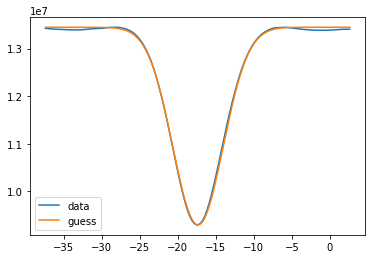

In [167]:
plt.plot(x_axis, ccf_data, label="data")
#plt.plot(x_axis, zero_shifted_CCF_data, label="zero_shift")
plt.plot(x_axis, gauss(x_axis, [amp_og_guess, -17.35, 3.3, offset_og_guess]), label="guess")
plt.legend()

In [168]:
np.mean(s_pd_clean["vrad"]*0.001)

-17.42195589041096

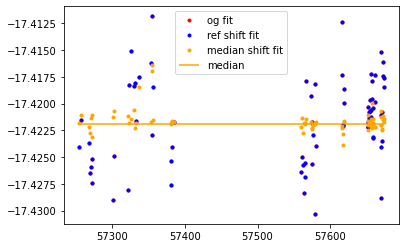

In [661]:
#plt.plot(s_pd_clean["vrad"]*0.001, label = "rvs")
plt.plot(s_pd_clean["bjd"], mu_og_list, ".", label = "og fit", color= 'r')
plt.plot(s_pd_clean["bjd"], mu_ref_list,".", label = "ref shift fit", color="b")
plt.plot(s_pd_clean["bjd"], mu_zero_list, ".",label = "median shift fit", color="orange")
plt.hlines(y=np.mean(s_pd_clean["vrad"]*0.001), xmin= np.min(s_pd_clean["bjd"]), xmax=np.max(s_pd_clean["bjd"]), label="median", color="orange")
#plt.xlim(0, 38)
#plt.ylim(-18, -17)
plt.legend()


In [109]:
mu_zero_list

[-1.9973027703578794,
 -2.691318111914816,
 -2.08997443272414,
 0.8596444035470328,
 -1.7113198978467006,
 5.749987637215351,
 1.4450753864884964,
 215.67776085010857,
 -3.0964779806756626,
 136.68964229910074,
 -4.999601281842505,
 2.4982310276965816,
 -4.260908648971264,
 -5.401078479117407,
 -3.069603329394658,
 -3.49717115445915,
 1.7919453695895209,
 29.99639898000477,
 1.7551961212946399,
 -4.748831177568275,
 -1.1704986067594123,
 -3.2719870484474294,
 -1.6266378989723618,
 -3.017535622709459,
 -2.6483137828880077,
 -0.14064460148852218,
 -1.3653058118746935,
 -2.128318724110954,
 1.816164570129345,
 -1.0476378592903746,
 -5.003960695990021,
 -4.38061744554706,
 -3.3945110233182025,
 -1.65113648905103,
 -2.35119550788295,
 -3.0691013117348804,
 -5.062708294550529,
 -1.1905989843878266,
 -1.5216249899256613,
 -19.861872885377995,
 -5.584366687732861,
 -3.4522648291246827,
 -4.089222228657457,
 -4.7881448846575845,
 -4.021613687252378,
 -2.9022838884793662,
 -2.351163795261693,
 -